In [41]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import DataFrame
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import PCA, PCAModel
import seaborn as sns
import numpy as np
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time
from os.path import isdir
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel

In [38]:
def assemble_features(dataframe: DataFrame, features_columns):
    assembler = VectorAssembler(inputCols=features_columns, outputCol='features')
    return assembler.transform(dataframe)


def scale_features(dataframe: DataFrame, with_mean=True, with_std=True):
    scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=with_mean, withStd=with_std).fit(
        dataframe)
    return scaler.transform(dataframe)


def corr_features(dataframe: DataFrame, method='pearson'):
    return Correlation.corr(dataframe, "features", method=method).head()[0].toArray()


def write_training_time(path:str, training_time):
    with open("{}/training_time.txt".format(path), 'w') as f:
        f.write('{:.2f}'.format(training_time))


def read_training_time(path:str):
    with open("{}/training_time.txt".format(path)) as f:
        result = float(f.read())
    return result


def read_models_number(path:str):
    with open("{}/models_number.txt".format(path)) as f:
        result = int(f.read())
    return result


def write_models_number(path:str, models_number):
    with open("{}/models_number.txt".format(path), 'w') as f:
        f.write(str(models_number))


def show_best_model(model):
    print("Got best {} among {} in {} seconds".format(model.model_name, model.models_number, model.training_time))


def show_confusion_matrix(predictions: DataFrame, model_name: str):
    metrics = MulticlassMetrics(predictions.select('prediction', 'label').rdd)
    print('Accuracy for {}: {:.2f}%'.format(model_name, metrics.accuracy*100))
    sns.heatmap(metrics.confusionMatrix().toArray(), annot=True)
    plt.savefig('{}.png'.format(model_name))
    plt.show()


def show_auc(predictions: DataFrame, model_name: str):
    print("AUC for {}: {}".format(model_name, BinaryClassificationEvaluator().evaluate(predictions)))


def evaluate_model(df_test: DataFrame, model_builder):
    lr_predictions = model_builder.model.transform(df_test)
    show_auc(lr_predictions, model_builder.model_name)
    show_confusion_matrix(lr_predictions, model_builder.model_name)



In [3]:
breast_cancer_data = spark.read.options(header=True, inferSchema='True').csv("data/breast cancer.csv")

In [4]:
class Preprocessor:
    def __init__(self, dataframe: DataFrame, true_condition, label_column: str, features_columns, normalize=True):
        self.dataframe = assemble_features(dataframe, features_columns)
        if normalize:
            self.dataframe = scale_features(self.dataframe, True, True)
        self.dataframe = self.dataframe.withColumn("label", true_condition(col(label_column)))
        features = col('scaled_features').alias('features') if normalize else col('features')
        self.dataframe = self.dataframe.select("label", features)

In [5]:
def preprocess_data(dataframe: DataFrame):
    preprocessor = Preprocessor(dataframe, lambda d: (d == 'M').cast('float'), 'diagnosis', dataframe.columns[2:], True)
    return preprocessor.dataframe


def save_correlation_matrix(dataframe: DataFrame):
    correlation_matrix = corr_features(dataframe)
    sns.heatmap(correlation_matrix)
    plt.savefig('correlation_matrix.png')
    plt.show()

In [6]:
n_features = len(breast_cancer_data.columns[2:])
print("n_features:{}".format(n_features))
df = preprocess_data(breast_cancer_data)

n_features:30


In [7]:
pca_model: PCAModel = PCA(k=n_features, inputCol='features', outputCol='pca_features').fit(df)

In [8]:
np.sum(pca_model.explainedVariance[:15])

0.9864881227145469

In [9]:
(df_train, df_test) = df.randomSplit([0.8, 0.2])

In [36]:
class LogisticRegressionBuilder:
    def __init__(self, training_df: DataFrame):
        self.model_name = 'Logistic Regression'
        if isdir(self.model_name):
            self.model = LogisticRegressionModel.load(self.model_name)
            self.training_time = read_training_time(self.model_name)
            self.models_number = read_models_number(self.model_name)
        else:
            lr = LogisticRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8)
            param_grid = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
                .addGrid(lr.elasticNetParam, [0, 0.25, 0.5, 0.75, 1]) \
                .build()
            cross_validation = CrossValidator(estimator=lr,
                                              estimatorParamMaps=param_grid,
                                              evaluator=BinaryClassificationEvaluator(),
                                              numFolds=3)
            self.models_number = len(param_grid)
            start = time.time()
            self.model = cross_validation.fit(training_df).bestModel
            self.training_time = time.time() - start
            self.model.save(self.model_name)
            write_training_time(self.model_name, self.training_time)
            write_models_number(self.model_name, self.models_number)
        show_best_model(self)


In [37]:
lrb = LogisticRegressionBuilder(df_train)


Got best Logistic Regression among 15 in 66.8 seconds


AUC for Logistic Regression: 0.9970760233918129
Accuracy for Logistic Regression: 98.35%


/home/mathias/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


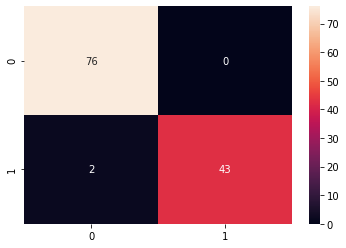

In [46]:
evaluate_model(df_test, lrb)

In [39]:
class RandomForestBuilder:
    def __init__(self, df_train: DataFrame):
        self.model_name = 'Random Forest'
        if isdir(self.model_name):
            self.model = RandomForestClassificationModel.load(self.model_name)
            self.training_time = read_training_time(self.model_name)
            self.models_number = read_models_number(self.model_name)
        else:
            rf = RandomForestClassifier(impurity='gini', numTrees=400)
            param_grid = ParamGridBuilder() \
                .addGrid(rf.impurity, ['gini', 'entropy']) \
                .addGrid(rf.maxDepth, [3, 5, 10, 15, 20]) \
                .build()
            cross_validation = CrossValidator(estimator=rf,
                                              estimatorParamMaps=param_grid,
                                              evaluator=BinaryClassificationEvaluator(),
                                              numFolds=3)
            self.models_number = len(param_grid)
            start = time.time()
            self.model = cross_validation.fit(df_train).bestModel
            self.training_time = time.time() - start
            self.model.save(self.model_name)
            write_training_time(self.model_name, self.training_time)
            write_models_number(self.model_name, self.models_number)
        show_best_model(self)
        

In [42]:
rfb = RandomForestBuilder(df_train)

Got best Random Forest among 10 in 48.43498516082764 seconds


AUC for Random Forest: 0.9976608187134502
Accuracy for Random Forest: 98.35%


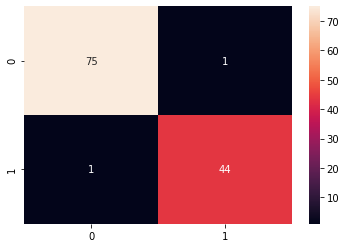

In [47]:
evaluate_model(df_test, rfb)

In [48]:
from pyspark.ml.classification import LinearSVC, LinearSVCModel

class SVMBuilder:
    def __init__(self, training_df: DataFrame):
        self.model_name = 'Linear SVC'
        if isdir(self.model_name):
            self.model = LinearSVCModel.load(self.model_name)
            self.training_time = read_training_time(self.model_name)
            self.models_number = read_models_number(self.model_name)
        else:
            svc = LinearSVC(maxIter=100, regParam=0.1)
            param_grid = ParamGridBuilder() \
                .addGrid(svc.regParam, [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 50, 100]) \
                .build()
            cross_validation = CrossValidator(estimator=svc,
                                              estimatorParamMaps=param_grid,
                                              evaluator=BinaryClassificationEvaluator(),
                                              numFolds=3)
            self.models_number = len(param_grid)
            start = time.time()
            self.model = cross_validation.fit(training_df).bestModel
            self.training_time = time.time() - start
            self.model.save(self.model_name)
            write_training_time(self.model_name, self.training_time)
            write_models_number(self.model_name, self.models_number)
        show_best_model(self)

In [49]:
svm_builder = SVMBuilder(df_train)

Got best Linear SVC among 10 in 130.51 seconds


AUC for Linear SVC: 0.9973684210526316
Accuracy for Linear SVC: 99.17%


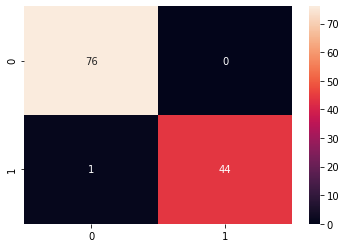

In [50]:
evaluate_model(df_test, svm_builder)

In [51]:
svm_builder.model.getRegParam()

0.01

In [52]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel

class MLPBuilder:
    def __init__(self, training_df: DataFrame):
        self.model_name = 'MLP'
        if isdir(self.model_name):
            self.model = MultilayerPerceptronClassificationModel.load(self.model_name)
            self.training_time = read_training_time(self.model_name)
            self.models_number = read_models_number(self.model_name)
        else:
            mlp = MultilayerPerceptronClassifier(maxIter=100, stepSize=0.1, layers=[30, 2])
            param_grid = ParamGridBuilder() \
                .addGrid(mlp.stepSize, [0.001, 0.01, 0.1]) \
                .addGrid(mlp.layers, [[30, 2], [30, 64, 2], [30, 64, 64, 2], [30, 64, 128, 32, 2]]) \
                .build()
            cross_validation = CrossValidator(estimator=mlp,
                                              estimatorParamMaps=param_grid,
                                              evaluator=BinaryClassificationEvaluator(),
                                              numFolds=3)
            self.models_number = len(param_grid)
            start = time.time()
            self.model = cross_validation.fit(training_df).bestModel
            self.training_time = time.time() - start
            self.model.save(self.model_name)
            write_training_time(self.model_name, self.training_time)
            write_models_number(self.model_name, self.models_number)
        show_best_model(self)

In [53]:
mlp_builder = MLPBuilder(df_train)

Got best MLP among 12 in 58.36 seconds


In [54]:
mlp_builder.model.getLayers()

[30, 64, 2]

AUC for MLP: 1.0
Accuracy for MLP: 99.17%


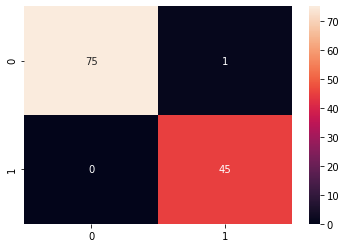

In [55]:
evaluate_model(df_test, mlp_builder)

In [57]:
mlp_builder.model.getStepSize()

0.001

In [58]:
range(10)

range(0, 10)

In [60]:
for i in range(10):
    print(i)


0
1
2
3
4
5
6
7
8
9


In [62]:
np.array([1,2,3])[:3]

array([1, 2, 3])